In [1]:
from rubiks.cube import RubiksCube
from rubiks.env import RubiksCubeEnv
from dqn.model import DQN
import gymnasium as gym
import random, math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Initialize environment and seeds
env = RubiksCubeEnv(size=3, scramble_moves=1)

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 42
random.seed(seed)
torch.manual_seed(seed)
env.reset(seed=seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [ ]:
# Training loop (No Replay Buffer and No Target Network)
GAMMA = 0.99
EPS_START = 0.9 # Initial exploration rate, 1.0 means 100% exploration, 0.0 means 100% exploitation
EPS_END = 0.01
EPS_DECAY = 0.001
LEARNING_RATE = 3e-4

# Reset the environment
env.reset(seed=seed)
input_dim = env.observation_space.shape[0]  # 6 * size^2
output_dim = env.action_space.n  # 12 (6 faces * 2 rotations)

# Reset the model weights
policy_net = DQN(input_dim, output_dim)  # Initialize with random weights and biases
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
loss_fn = nn.SmoothL1Loss()
epsilon = EPS_START

num_episodes = 2000
max_steps = 10

# Reward tracking
reward_list = []

for episode in range(num_episodes):
    # Reset the game state for each episode
    state, info = env.reset()
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0) # [1, input_dim]
    total_reward = 0
    
    for step in range(max_steps):
        # Select action (e-greedy)
        if random.random() < epsilon: # explore
            action_tensor = env.action_space.sample()
        else: # exploit
            with torch.no_grad():
                q_values = policy_net(state_tensor) # [1, output_dim], output_dim would be 12 as there are 12 actions
            action_tensor = torch.max(q_values, dim=1).indices.item()  # Get the index of the action with the highest Q-value
            
        # Perform action in the environment
        observation, reward, terminated, truncated, _ = env.step(action_tensor)
        next_state_tensor = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        reward_tensor = torch.tensor([reward], device=device)
        action_tensor = torch.tensor([[action_tensor]], device=device)
        done = terminated or truncated
        total_reward += reward
        
        # Get predicted Q-value for the current state-action pair
        state_action_values = policy_net(state_tensor)
        state_action_values = state_action_values.gather(1, action_tensor).squeeze(1)
        
        # Calculate target Q-value
        with torch.no_grad():
            # NOTE: We aren't using a target network here, just the policy_net itself. This code leads to the 'chasing a moving target' problem.
            next_state_values = policy_net(next_state_tensor)  # [1, output_dim]
        next_state_values = torch.max(next_state_values, dim=1).values  # Find the max q-value on the action dimension
        expected_state_action_values = reward_tensor if done else reward_tensor + GAMMA * next_state_values
    
        # Calculate loss
        loss = loss_fn(state_action_values, expected_state_action_values) # input, target
        
        optimizer.zero_grad() # Clear gradients
        loss.backward() # Backpropagation, this computes gradients
        optimizer.step() # Update weights based on gradients
        
        # Move to the next state
        state_tensor = next_state_tensor
        
        if done:
            break
        
    # Decay epsilon (less exploration over time)
    epsilon = max(EPS_END, epsilon - EPS_DECAY)
    
    reward_list.append(total_reward)
    
    print(f"Episode {episode+1}, Total Reward: {total_reward:.1f}, Epsilon: {epsilon:.3f}")

In [ ]:
# Plot rewards moving avg over time
window_size = 50  # adjust this as needed
reward_array = np.array(reward_list)
moving_avg = np.convolve(reward_array, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(reward_list, color='lightgray', label='Raw Reward')
plt.plot(range(window_size - 1, len(reward_list)), moving_avg, color='blue', label=f'{window_size}-Step Moving Avg')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Reward per Step with Moving Average')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Plot rewards moving avg over time
window_size = 50  # adjust this as needed
reward_array = np.array(reward_list)
moving_avg = np.convolve(reward_array, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(reward_list, color='lightgray', label='Raw Reward')
plt.plot(range(window_size - 1, len(reward_list)), moving_avg, color='blue', label=f'{window_size}-Step Moving Avg')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Reward per Step with Moving Average')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# DQN w Replay Buffer

In [2]:
from collections import namedtuple, deque

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'terminated'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
# Training loop (No Replay Buffer and No Target Network)
GAMMA = 0.99
EPS_START = 0.9 # Initial exploration rate, 1.0 means 100% exploration, 0.0 means 100% exploitation
EPS_END = 0.01
EPS_DECAY = 0.001
LEARNING_RATE = 3e-4

# Reset the environment
env.reset(seed=seed)
input_dim = env.observation_space.shape[0]  # 6 * size^2
output_dim = env.action_space.n  # 12 (6 faces * 2 rotations)

# Reset the model weights
policy_net = DQN(input_dim, output_dim)  # Initialize with random weights and biases
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
loss_fn = nn.SmoothL1Loss()
epsilon = EPS_START

num_episodes = 2000
max_steps = 10

memory = ReplayMemory(10000)  # Initialize replay memory with a capacity of 10,000
BATCH_SIZE = 32  # Size of the batch for training

# Reward tracking
reward_list = []

for episode in range(num_episodes):
    # Reset the game state for each episode
    state, info = env.reset()
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0) # [1, input_dim]
    total_reward = 0
    
    for step in range(max_steps):
        # Select action (e-greedy)
        if random.random() < epsilon: # explore
            action_tensor = torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long) # [1, 1] tensor for action
        else: # exploit
            with torch.no_grad():
                q_values = policy_net(state_tensor) # [1, output_dim], output_dim would be 12 as there are 12 actions
            action_tensor = torch.max(q_values, dim=1).indices.view(1, 1)  # Get the index of the action with the highest Q-value
            
        # Perform action in the environment
        observation, reward, terminated, truncated, _ = env.step(action_tensor.item())
        next_state_tensor = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        reward_tensor = torch.tensor([reward], device=device) # [1] tensor for reward
        terminated_batch = torch.tensor([terminated], device=device, dtype=torch.bool) # [1] tensor for termination status
        done = terminated or truncated
        total_reward += reward
        
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        
        # Store transition in replay memory
        memory.push(state_tensor, action_tensor, next_state_tensor, reward_tensor, terminated_batch)
        
        if len(memory) < BATCH_SIZE:
            break
        # Sample a batch from memory
        transitions = memory.sample(BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        
        
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = policy_net(state_batch).gather(1, action_batch)
        
        # Calculate target Q-value
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            # NOTE: We aren't using a target network here, just the policy_net itself. This code leads to the 'chasing a moving target' problem.
            next_q = policy_net(next_state_batch)              # [BATCH, output_dim]
            next_state_values[non_final_mask] = policy_net(non_final_next_states).max(1).values
        
        # Compute the expected Q values
        expected_state_action_values = (reward_batch + GAMMA * next_state_values).unsqueeze(1)
    
        # Calculate loss
        loss = loss_fn(state_action_values, expected_state_action_values) # input, target
        
        optimizer.zero_grad() # Clear gradients
        loss.backward() # Backpropagation, this computes gradients
        optimizer.step() # Update weights based on gradients
        
        # Move to the next state
        state_tensor = next_state_tensor
        
        if done:
            break
        
    # Decay epsilon (less exploration over time)
    epsilon = max(EPS_END, epsilon - EPS_DECAY)
    
    reward_list.append(total_reward)
    
    print(f"Episode {episode+1}, Total Reward: {total_reward:.1f}, Epsilon: {epsilon:.3f}")

Episode 1, Total Reward: 0.0, Epsilon: 0.899
Episode 2, Total Reward: 0.0, Epsilon: 0.898
Episode 3, Total Reward: 0.0, Epsilon: 0.897
Episode 4, Total Reward: 1.0, Epsilon: 0.896
Episode 5, Total Reward: 0.0, Epsilon: 0.895
Episode 6, Total Reward: 0.0, Epsilon: 0.894
Episode 7, Total Reward: 0.0, Epsilon: 0.893
Episode 8, Total Reward: 0.0, Epsilon: 0.892
Episode 9, Total Reward: 0.0, Epsilon: 0.891
Episode 10, Total Reward: 0.0, Epsilon: 0.890
Episode 11, Total Reward: 0.0, Epsilon: 0.889
Episode 12, Total Reward: 0.0, Epsilon: 0.888
Episode 13, Total Reward: 0.0, Epsilon: 0.887
Episode 14, Total Reward: 0.0, Epsilon: 0.886
Episode 15, Total Reward: 0.0, Epsilon: 0.885
Episode 16, Total Reward: 0.0, Epsilon: 0.884
Episode 17, Total Reward: 0.0, Epsilon: 0.883
Episode 18, Total Reward: 0.0, Epsilon: 0.882
Episode 19, Total Reward: 0.0, Epsilon: 0.881
Episode 20, Total Reward: 0.0, Epsilon: 0.880
Episode 21, Total Reward: 0.0, Epsilon: 0.879
Episode 22, Total Reward: 0.0, Epsilon: 0.8

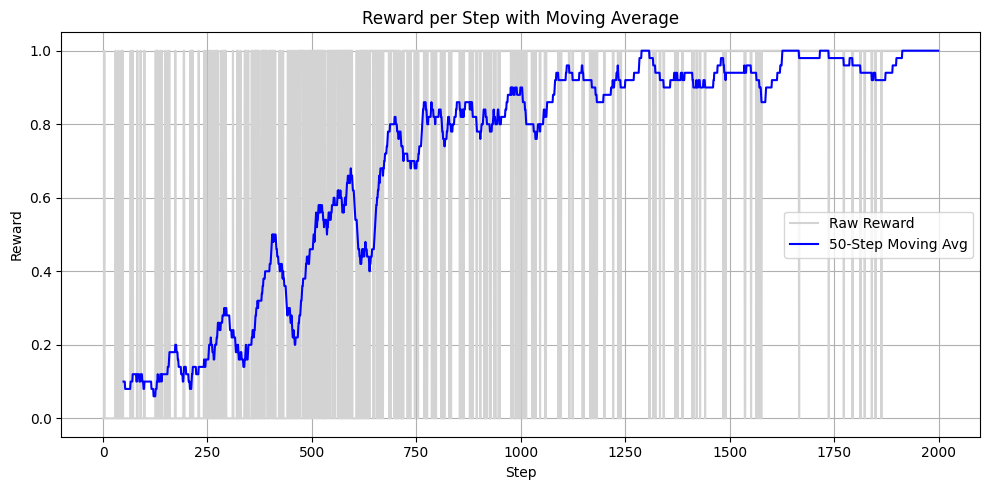

In [6]:
# Plot rewards moving avg over time
import matplotlib.pyplot as plt
import numpy as np

window_size = 50  # adjust this as needed
reward_array = np.array(reward_list)
moving_avg = np.convolve(reward_array, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(reward_list, color='lightgray', label='Raw Reward')
plt.plot(range(window_size - 1, len(reward_list)), moving_avg, color='blue', label=f'{window_size}-Step Moving Avg')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Reward per Step with Moving Average')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# DQN w Replay Buffer & Target Net